<a href="https://colab.research.google.com/github/rrfsantos/Airbnb-Segmentacao-dos-principais-assuntos-das-reviews/blob/main/2_Airbnb_LDA_WorldCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyLDAvis

In [17]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import warnings

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/Airbnb/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Carregando dataset com 30% das reviews
df = pd.read_csv('clean_reviews_en_30.csv', engine='python')

In [6]:
# Verificando as dimensões dos datasets
print("Variáveis:\t{}\nEntradas:\t{}\n".format(df.shape[1], df.shape[0]))

Variáveis:	7
Entradas:	89002



In [7]:
df.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments,comments_en
0,40652300,710542759,2020-11-22,20863004,Teresa,o apartamento é muitíssimo bem localizado com ...,apart well locat necess amen long stay marcia ...


#### Vetorizando as palavras das reviews

In [18]:
# Vetorizando as palavras
vectorizer = CountVectorizer(analyzer='word',       
                            ngram_range = (1,1),  # uni, bi, trigrams...
                            token_pattern='[A-Za-z0-9]{3,}'  # num chars > 3 - para ser qualificado como token
                            )

data_vectorized = vectorizer.fit_transform(df.comments_en.values.astype('U'))

#### Alocação Latente de Dirichlet (LDA) - Análise de tópicos e estudo de termos mais frequentes

In [19]:
# Utilizando GridSearchCV para encontrar melhor modelo LDA

# Parâmetros de busca
search_params = {'n_components': [3, 5, 10, 15], 'learning_decay': [.3, .5, .7, .9]}

# Inicializa o modelo
lda = LatentDirichletAllocation()

# Inicializa Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Faz a Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.3, 0.5, 0.7, 0.9],
                         'n_components': [3, 5, 10, 15]})

In [20]:
# Utilizando o melhor modelo LDA

# Melhor modelo
best_lda_model = model.best_estimator_

# Hiperparâmetros do modelo
print("Melhores parâmetros: ", model.best_params_)

# Probabilidade logarítmica
print("Melhor score de probabilidade logarítmica: ", model.best_score_) 

# Perplexidade
print("Perplexidade do modelo: ", best_lda_model.perplexity(data_vectorized))

# Utilizar o melhor modelo
lda_output = best_lda_model.transform(data_vectorized)

Melhores parâmetros:  {'learning_decay': 0.9, 'n_components': 3}
Melhor score de probabilidade logarítmica:  -2603233.304640723
Perplexidade do modelo:  742.509876791096


In [21]:
# Visualizando os tópicos via pyLDAvis
pyLDAvis.enable_notebook() 
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'lda.html') 
pyLDAvis.display(panel)

#### WordCloud

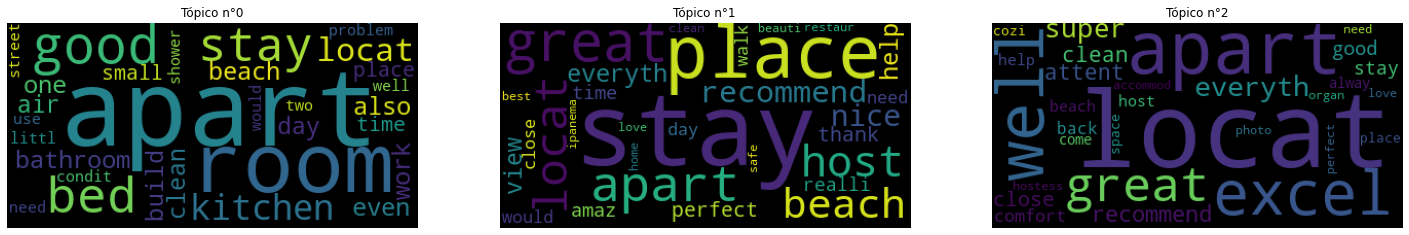

In [22]:
# Plotando a WordCloud de cada tópico
tf_feature_names = vectorizer.get_feature_names()
fig = plt.figure(figsize=(25,20))
for i in range(len(best_lda_model.components_)):
    topic = best_lda_model.components_[i]
    tupleList = [(tf_feature_names[i], int(topic[i]/topic.sum()*10000)) for i in range(len(topic))]
    ax = fig.add_subplot(3,3,i+1)
    wordcloud = WordCloud(max_words=30).generate_from_frequencies(dict(tupleList))
    ax.imshow(wordcloud)
    ax.set_title('Tópico n°{}' .format(i))
    ax.axis('off');